<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/main/BiasCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats


In [2]:
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

# Hypothesis

## Bias against

Model

In [3]:

mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_0, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_0, posterior_mean, posterior_var**0.5))
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

### Analytic (using posterior density)

In [4]:
bias_against = idata.posterior['logBR_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)

### Simulation (estimating marginal likelihood)

In [5]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)


#### Plot

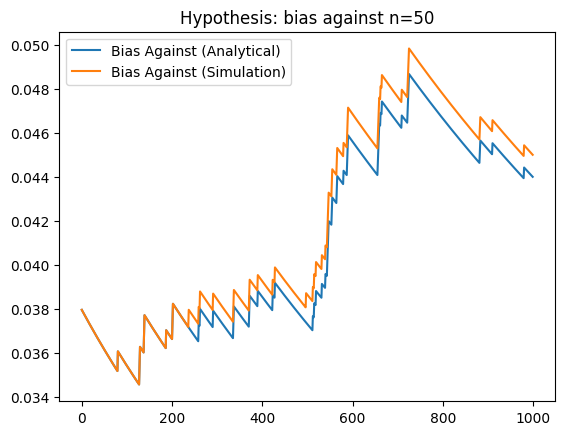

In [6]:
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: bias against n=50")
plt.legend()

## Bias in favor in **1D**

In [7]:
mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
delta = 0.05
mu_lower = mu_0 - delta
mu_upper = mu_0 + delta
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    xl_ = pm.Normal('xl_', mu=mu_lower, sigma=1, shape=n)
    xu_ = pm.Normal('xu_', mu=mu_upper, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)

    posterior_meanl = (mu_prior_mean/mu_prior_sigma**2 + xl_.sum()/1)*posterior_var
    posterior_meanu = (mu_prior_mean/mu_prior_sigma**2 + xu_.sum()/1)*posterior_var

    posterior_prior_pdl = pm.Deterministic("posterior_prior_pdl",
                                          normal_logp(mu_0, posterior_meanl, posterior_var**0.5))
    posterior_prior_pdu = pm.Deterministic("posterior_prior_pdu",
                                          normal_logp(mu_0, posterior_meanu, posterior_var**0.5))

    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_prior_pdl-prior_prior_pd) # pm.math.exp()
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_prior_pdu-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pdlower = pm.Deterministic("likelihood_prior_pdlower", normal_logp(xl_,mu_0,1).sum())
    likelihood_prior_pdupper = pm.Deterministic("likelihood_prior_pdupper", normal_logp(xu_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)

use = 1000
marginal_likelihoodslower = np.zeros(list(idata.posterior['xl_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoodslower[:,:,:,i] = normal_logp_np(idata.posterior['xl_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoodsupper = np.zeros(list(idata.posterior['xu_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoodsupper[:,:,:,i] = normal_logp_np(idata.posterior['xu_'].values,m,1)


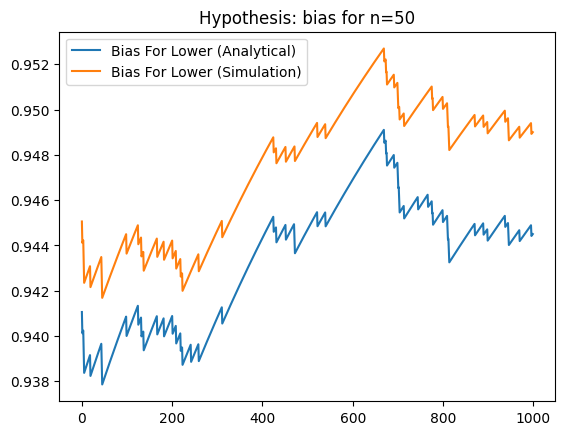

In [8]:
marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoodslower.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mllower = (idata.posterior['likelihood_prior_pdlower'].values.ravel()-marginal_likelihoods_lower) > 0
bias_for_ml_mcilower = bias_for_mllower.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

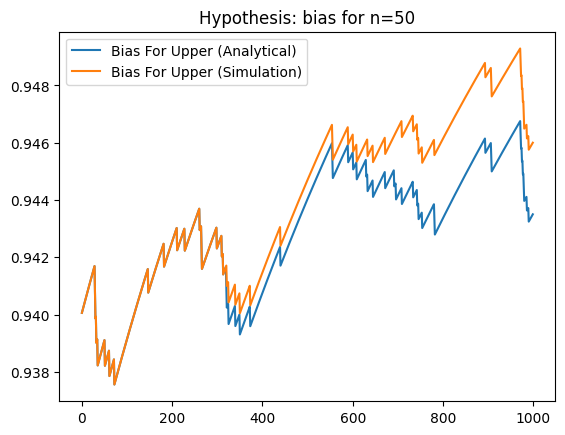

In [9]:
marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoodsupper.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mlupper = (idata.posterior['likelihood_prior_pdupper'].values.ravel()-marginal_likelihoods_upper) > 0
bias_for_ml_mciupper = bias_for_mlupper.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

Alt. marginal likelihood calculation

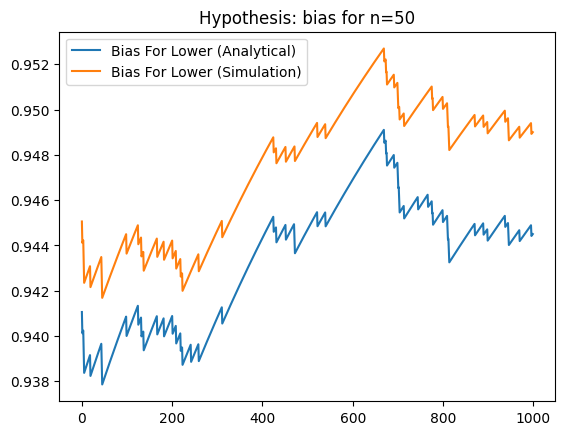

In [10]:
use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu_'].values.ravel()[:use]  # Shape (use,)
xl_samples = idata.posterior['xl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['xu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdlower'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdupper'].values.ravel()

bias_against_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) <= 0
bias_against_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) <= 0

bias_against_ml_mci_lower = bias_against_ml_lower.cumsum() / np.arange(1, len(bias_against_ml_lower) + 1)
bias_against_ml_mci_upper = bias_against_ml_upper.cumsum() / np.arange(1, len(bias_against_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


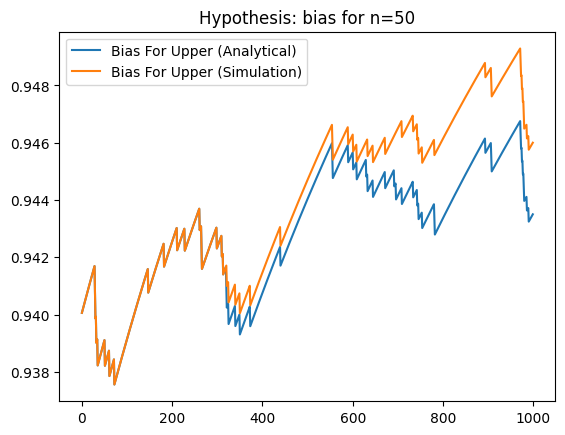

In [11]:
use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu_'].values.ravel()[:use]  # Shape (use,)
xu_samples = idata.posterior['xu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdupper'].values.ravel()

bias_against_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) <= 0

bias_against_ml_mci_upper = bias_against_ml_upper.cumsum() / np.arange(1, len(bias_against_ml_upper) + 1)

plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

## Beta Binomial model


Using specification from Example 2 in this paper, where true value of bias in favor is 0.692:

Michael Evans (2016),Measuring statistical evidence using relative belief,
Computational and Structural Biotechnology Journal,
Volume 14, Pages 91-96, ISSN 2001-0370,
https://doi.org/10.1016/j.csbj.2015.12.001.

Explictly

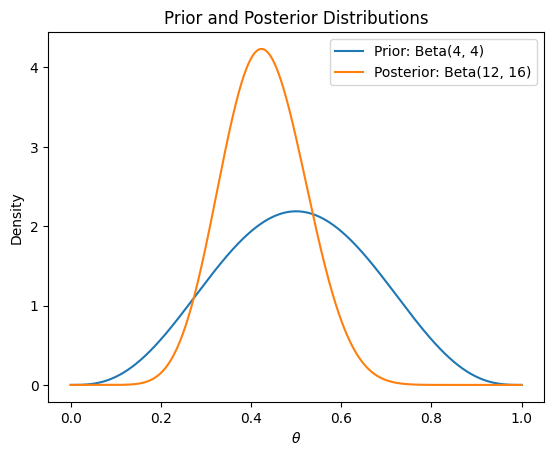

Bayes Factor RB(1/2 | x): 1.421017783028739
0.95-Credible Region: (0.2547988066317378, 0.6120160697403181)
Length of the credible region: 0.35721726310858026
Probability RB(theta | x) <= RB(0.5 | x) given nx=8: 0.31241
Bias against H0: θ = 1/2: 0.165878
Relative belief ratio at theta = 0.5: 1.421017783028739
Probability that RB(theta|0.5) <= 1 under the prior: 0.266


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.special import gamma

# Given data
x = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])
n = len(x)
n_x = np.sum(x)

# Prior parameters
alpha_0 = 4
beta_0 = 4

# Posterior parameters
alpha_post = n_x + alpha_0
beta_post = n - n_x + beta_0

# Plotting the prior and posterior distributions
theta = np.linspace(0, 1, 1000)
prior = beta.pdf(theta, alpha_0, beta_0)
posterior = beta.pdf(theta, alpha_post, beta_post)

plt.plot(theta, prior, label=f'Prior: Beta({alpha_0}, {beta_0})')
plt.plot(theta, posterior, label=f'Posterior: Beta({alpha_post}, {beta_post})')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions')
plt.legend()
plt.show()



import math

def beta_distribution(x, a, b):
    return (math.gamma(a + b) / (math.gamma(a) * math.gamma(b))) * (x ** (a - 1)) * ((1 - x) ** (b - 1))

def bayes_factor(theta, nx, n, alpha0, beta0):
    return (beta_distribution(theta, nx + alpha0, n - nx + beta0)) / (beta_distribution(theta, alpha0, beta0))

def probability_rb_less_than_given(theta, nx, n, alpha0, beta0, threshold):
    count = 0
    samples = 100000
    for _ in range(samples):
        random_theta = np.random.beta(nx + alpha0, n - nx + beta0)
        if bayes_factor(random_theta, nx, n, alpha0, beta0) <= threshold:
            count += 1
    return count / samples

# Given data
nx = 8
n = 20
alpha0 = 4
beta0 = 4

theta0 = 0.5

RB_theta_0 =bayes_factor(theta0, nx, n, alpha0, beta0)

print("Bayes Factor RB(1/2 | x):", RB_theta_0)
# Calculate the 0.95-credible region
credible_region = beta.interval(0.95, alpha_post, beta_post)
credible_region_length = credible_region[1] - credible_region[0]
print(f"0.95-Credible Region: {credible_region}")
print(f"Length of the credible region: {credible_region_length}")
print("Probability RB(theta | x) <= RB(0.5 | x) given nx=8:", probability_rb_less_than_given(theta, nx, n, alpha0, beta0, RB_theta_0))



def bias_against_H0(theta, nx, n, alpha0, beta0):
    count = 0
    samples = 1000000
    for _ in range(samples):
        random_theta = np.random.beta(nx + alpha0, n - nx + beta0)
        if bayes_factor(random_theta, nx, n, alpha0, beta0) <= 1:
            count += 1
    return count / samples

# Given data
bias = bias_against_H0(theta0, nx, n, alpha0, beta0)

print("Bias against H0: θ = 1/2:", bias)

# Function to compute the relative belief ratio
def relative_belief_ratio(theta, alpha_prior, beta_prior, alpha_post, beta_post):
    prior_density = beta.pdf(theta, alpha_prior, beta_prior)
    posterior_density = beta.pdf(theta, alpha_post, beta_post)
    with np.errstate(divide='ignore', invalid='ignore'):
        rb_ratio = np.where(prior_density > 0, posterior_density / prior_density, np.inf)
    return rb_ratio

# Compute the probability that RB(theta|0.5) <= 1 under the prior theta = 0.5
theta_samples = np.linspace(0, 1, 1000)
rb_values = relative_belief_ratio(theta_samples, alpha0, beta0, alpha_post, beta_post)
probability = np.mean(rb_values <= 1)

print(f"Relative belief ratio at theta = 0.5: {RB_theta_0}")
print(f"Probability that RB(theta|0.5) <= 1 under the prior: {1-probability}")


### Bias against

In [113]:
### NOT THIS ONE

import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy.special import gammaln

def beta_logp(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

def beta_logp2(a, b, x):
    return pm.logp(pm.Beta.dist(alpha=a, beta=b), x)


n = 20
theta0 = 0.5
data = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # np.random.binomial(1, theta0, n)
alpha0, beta0 = 4, 4

with pm.Model() as modB:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    x = pm.Bernoulli("x", p=theta, shape=n, observed=data)

    prior_pd = pm.Deterministic("prior_pd", beta_logp(alpha0, beta0, theta))

    posterior_theta = pm.Beta("posterior_theta", alpha=np.sum(data) + alpha0, beta=n - np.sum(data) + beta0)

    posterior_pd = pm.Deterministic("posterior_pd", beta_logp(np.sum(data) + alpha0, n - np.sum(data) + beta0, theta))

    BR_prior = pm.Deterministic("BR_prior", pm.math.exp(posterior_pd / prior_pd))
    BR_prior3 = pm.Deterministic("BR_prior3", pm.math.exp(posterior_pd / theta))
    BR_prior4 = pm.Deterministic("BR_prior4", pm.math.exp(posterior_theta / prior_pd))

    # Calculate the log-likelihood for the prior
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", (beta_logp2(pm.math.sum(x) + alpha0, n - pm.math.sum(x) + beta0, theta)).sum())

    trace = pm.sample(2000, tune=1000)




In [14]:
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln, betaln

def beta_logp(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

def beta_logp_np(a, b, x):
    return (a - 1) * np.log(x) + (b - 1) * np.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))


#def beta_logp_np(alpha, beta, theta):
#    return (alpha - 1) * np.log(theta) + (beta - 1) * np.log(1 - theta) - betaln(alpha, beta)

In [49]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

def beta_logp(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

n = 20
theta0 = 0.5
data = [1, 1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0,0,0,0,0] #np.random.binomial(1, theta0, n)
alpha0, beta0 = 4, 4

with pm.Model() as modB:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    x = pm.Bernoulli("x", p=theta, shape=n)

    prior_pd = pm.Deterministic("prior_pd", beta_logp(alpha0, beta0, theta))

    posterior_theta = pm.Beta("posterior_theta", alpha=np.sum(data) + alpha0, beta=n - np.sum(data) + beta0)

    posterior_pd = pm.Deterministic("posterior_pd", beta_logp(np.sum(data) + alpha0, n - np.sum(data) + beta0, theta))

    #BR_prior = pm.Deterministic("BR_prior", pm.math.exp(posterior_theta / theta))
    BR_prior = pm.Deterministic("BR_prior", pm.math.exp(posterior_pd / prior_pd))


    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.Beta.dist(pm.math.sum(x) + alpha0, n - pm.math.sum(x) + beta0), theta).sum())

    trace = pm.sample(2000, tune=1000)


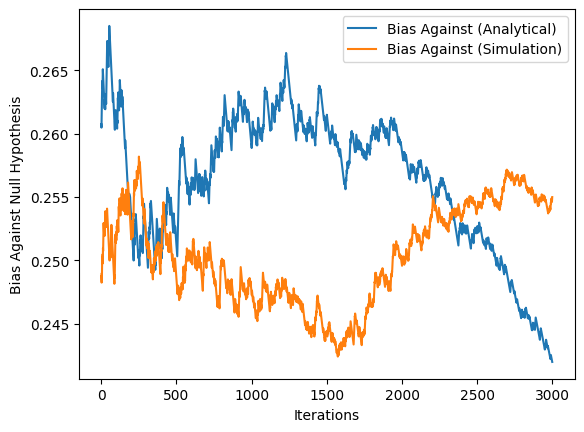

In [50]:
# Alt marginal likelihood

# Extract posterior samples
theta_samples = trace.posterior['theta'].values.ravel()[:1000]  # Shape (1000,)
x_samples = trace.posterior['x'].values  # Shape (chains, draws, n)


sum_x_samples = x_samples.sum(axis=-1)  # Shape (chains, draws)


marginal_likelihoods = beta_logp_np(sum_x_samples + alpha0, n - sum_x_samples + beta0, theta_samples[:, np.newaxis, np.newaxis])

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=0)).ravel()

# Convert TensorVariables to numpy arrays
likelihood_prior_pd = trace.posterior['likelihood_prior_pd'].values.ravel()

# Compute biases
bias_against_ml = (likelihood_prior_pd / log_marginal_likelihoods) <= 1

# Ensure they are numpy arrays
bias_against_ml = np.array(bias_against_ml)

# Compute cumulative mean of the biases
bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)


plt.plot( bias_against_mci[burn:], label='Bias Against (Analytical)')

plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')

plt.xlabel("Iterations")
plt.ylabel("Bias Against Null Hypothesis")
plt.legend()
plt.show()



## Bias in favor

Analytically (Using posterior density)

Using logbeta

In [143]:
#Current one

delta = 0.05
n = 20
theta0 = 0.5

data = np.random.binomial(1, theta0)
alpha0 = 4
beta0 = 4

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    prior_pdlower = pm.Deterministic("prior_pdlower", beta_logp(alpha0, beta0, theta-delta))
    prior_pdupper = pm.Deterministic("prior_pdupper", beta_logp(alpha0, beta0, theta+delta))


    posterior_pd1 = pm.Deterministic("posterior_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta-delta))
    #                                 beta_logp(pm.math.sum(xl_) +alpha0,  n-pm.math.sum(xl_) +beta0, theta-delta))
    posterior_pd2 = pm.Deterministic("posterior_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta+delta))

    logBR_prior_pd1 = pm.Deterministic("logBR_prior_pd1", posterior_pd1 - prior_pdlower)
    logBR_prior_pd2 = pm.Deterministic("logBR_prior_pd2", posterior_pd2 - prior_pdupper)

    # Likelihood for data
    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta-delta).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta+delta).sum())


    # Sample from posterior
    trace = pm.sample(2000, tune=2000)

bias_forlower = trace.posterior['logBR_prior_pd1'].values.ravel() >= 0
bias_forupper = trace.posterior['logBR_prior_pd2'].values.ravel() >= 0
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)

In [140]:
# Alternative alternative

delta = 0.05
n = 20
# theta0 = 0.5

data = np.random.binomial(n, theta0)
alpha0 = 4
beta0 = 4

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    prior_pdlower = pm.Deterministic("prior_pdlower", beta_logp(alpha0, beta0, theta-delta))
    prior_pdupper = pm.Deterministic("prior_pdupper", beta_logp(alpha0, beta0, theta+delta))


    posterior_pd1 = pm.Deterministic("posterior_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta-delta))
    #                                 beta_logp(pm.math.sum(xl_) +alpha0,  n-pm.math.sum(xl_) +beta0, theta-delta))
    posterior_pd2 = pm.Deterministic("posterior_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta+delta))

    #pm.Deterministic("posterior_prior_pd2", beta_logp(pm.math.sum(xu_) +alpha0,  n-pm.math.sum(xu_) +beta0, theta+delta))

    logBR_prior_pd1 = pm.Deterministic("logBR_prior_pd1", posterior_pd1 - prior_pdlower)
    logBR_prior_pd2 = pm.Deterministic("logBR_prior_pd2", posterior_pd2 - prior_pdupper)

    # Likelihood for data
    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", beta_logp(pm.math.sum(xl_) +alpha0,  n-pm.math.sum(xl_) +beta0, theta).sum())
    #likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", beta_logp(pm.math.sum(xu_) +alpha0,  n-pm.math.sum(xu_) +beta0, theta).sum())
    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta).sum())


    # Sample from posterior
    trace = pm.sample(2000, tune=2000)

bias_forlower = trace.posterior['logBR_prior_pd1'].values.ravel() >= 0
bias_forupper = trace.posterior['logBR_prior_pd2'].values.ravel() >= 0
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)




In [126]:
# Alternative
delta = 0.05
n = 20
theta0 = 0.5
data1 = np.random.binomial(1, theta0-delta, n)
data2 = np.random.binomial(1,theta0+delta, n)

alpha0 = 4
beta0 = 4

print(data1)
print(data2)

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    prior_pd = pm.Deterministic("prior_pd", beta_logp(alpha0, beta0, theta0))

    posterior_pd1 = pm.Deterministic("posterior_prior_pd1", beta_logp(np.sum(data1)+alpha0,  n-np.sum(data1)+beta0, theta))
    posterior_pd2 = pm.Deterministic("posterior_prior_pd2", beta_logp(np.sum(data2)+alpha0,  n-np.sum(data2)+beta0, theta))

    logBR_prior_pd1 = pm.Deterministic("logBR_prior_pd1", posterior_pd1 - prior_pd)
    logBR_prior_pd2 = pm.Deterministic("logBR_prior_pd2", posterior_pd2 - prior_pd)

    # Likelihood for data
    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", beta_logp(np.sum(data1)+alpha0,  n-np.sum(data1)+beta0, theta).sum())
    #likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", beta_logp(np.sum(data2)+alpha0,  n-np.sum(data2)+beta0, theta).sum())

    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta).sum())
    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1",  pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta0).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta).sum())


    # Sample from posterior
    trace = pm.sample(2000, tune=2000)

bias_forlower = trace.posterior['logBR_prior_pd1'].values.ravel() >= 0
bias_forupper = trace.posterior['logBR_prior_pd2'].values.ravel() >= 0
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)



[0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1]
[0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1]


0.6395001752371057
[ 0.45869631 -4.38282867 -0.89109239  1.43926379 -5.47665032  0.82620566
 -3.11440925  0.29048932  1.03040358 -1.4907785 ]


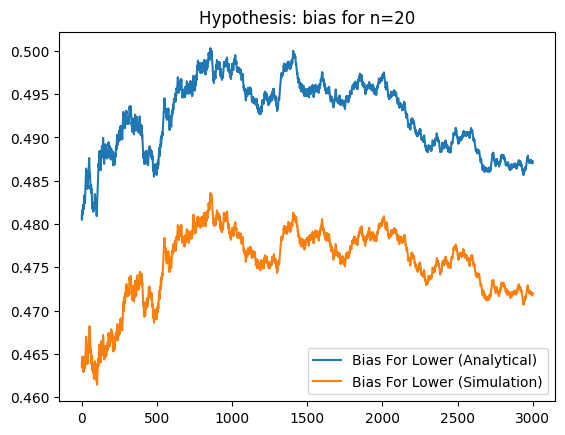

In [144]:
# Calculate the marginal likelihood for lower data
marginal_likelihoods_lower = []
for m in trace.posterior['theta'].values.ravel():
    marginal_likelihoods_lower.append(beta_logp_np(np.sum(data1) + alpha0, n - np.sum(data1) + beta0, m))

marginal_likelihoods_lower = np.log(np.exp(np.array(marginal_likelihoods_lower)).mean())

print(marginal_likelihoods_lower)
# Calculate bias for lower marginal likelihood
bias_for_mllower = (trace.posterior['likelihood_prior_pd1'].values.ravel() - marginal_likelihoods_lower) >= 0
bias_for_ml_mcilower = bias_for_mllower.cumsum() / np.arange(1, bias_for_mllower.shape[0] + 1)

# Output and plot
print(trace.posterior['likelihood_prior_pd1'].values.ravel()[:10])

plt.plot(bias_forlower_mci[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title(f"Hypothesis: bias for n={n}")
plt.legend()
plt.show()

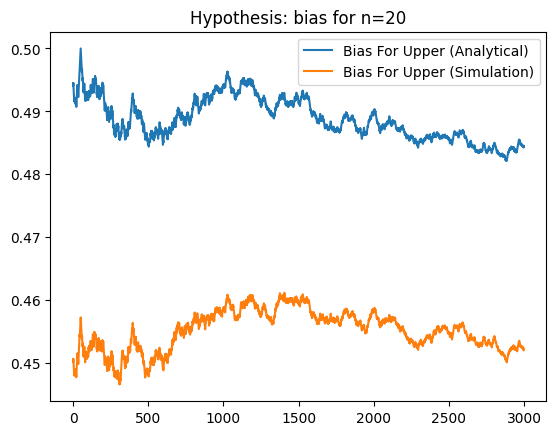

In [145]:
# Calculate the marginal likelihood for lower data
marginal_likelihoods_upper = []
for m in trace.posterior['theta'].values.ravel():
    marginal_likelihoods_upper.append(beta_logp_np(np.sum(data2) + alpha0, n - np.sum(data2) + beta0, m))

marginal_likelihoods_upper = np.log(np.exp(np.array(marginal_likelihoods_upper)).mean())

# Calculate bias for lower marginal likelihood
bias_for_mlupper = (trace.posterior['likelihood_prior_pd2'].values.ravel() - marginal_likelihoods_upper) >= 0  # Use a small tolerance for floating-point comparison
bias_for_ml_mciupper = bias_for_mlupper.cumsum() / np.arange(1, bias_for_mlupper.shape[0] + 1)

plt.plot(bias_forupper_mci[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title(f"Hypothesis: bias for n={n}")
plt.legend()
plt.show()


Alt. marginal likelihood calculation

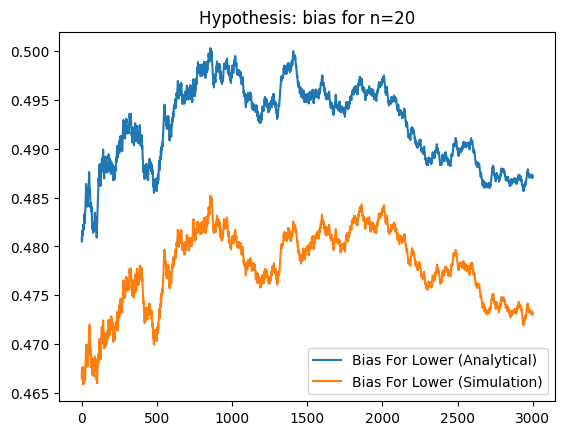

In [146]:
# Extract posterior samples
theta_samples = trace.posterior['theta'].values.ravel()[:1000]  # Shape (1000,)
xl_samples = trace.posterior['xl_'].values  # Shape (chains, draws, n)

# Sum xl_samples and xu_samples along the last axis
sum_xl_samples = xl_samples.sum(axis=-1)  # Shape (chains, draws)

marginal_likelihoods_lower = beta_logp_np(sum_xl_samples + alpha0, n - sum_xl_samples + beta0, theta_samples[:, np.newaxis, np.newaxis])

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=0)).ravel()

# Convert TensorVariables to numpy arrays
likelihood_prior_pd1 = trace.posterior['likelihood_prior_pd1'].values.ravel()

# Compute biases
bias_for_ml_lower = (likelihood_prior_pd1 - log_marginal_likelihoods_lower) >= 0

# Ensure they are numpy arrays
bias_for_ml_lower = np.array(bias_for_ml_lower)

# Compute cumulative mean of the biases
bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)

plt.plot(bias_forlower_mci[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.title(f"Hypothesis: bias for n={n}")
plt.legend()
plt.show()

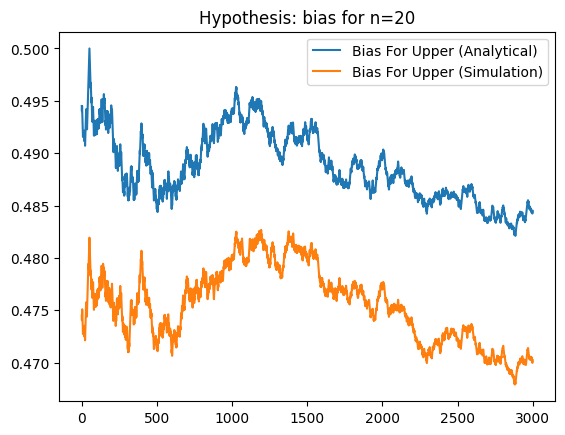

In [147]:
# Extract posterior samples
theta_samples = trace.posterior['theta'].values.ravel()[:1000]  # Shape (1000,)
xu_samples = trace.posterior['xu_'].values  # Shape (chains, draws, n)

# Sum xl_samples and xu_samples along the last axis
sum_xu_samples = xu_samples.sum(axis=-1)  # Shape (chains, draws)

marginal_likelihoods_upper = beta_logp_np(sum_xu_samples + alpha0, n - sum_xu_samples + beta0, theta_samples[:, np.newaxis, np.newaxis])

# Average the likelihoods over the samples
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=0)).ravel()

# Convert TensorVariables to numpy arrays
likelihood_prior_pd2 = trace.posterior['likelihood_prior_pd2'].values.ravel()

# Compute biases
bias_for_ml_upper = (likelihood_prior_pd2 - log_marginal_likelihoods_upper) >= 0

# Ensure they are numpy arrays
bias_for_ml_upper = np.array(bias_for_ml_upper)

# Compute cumulative mean of the biases
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_forupper_mci[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title(f"Hypothesis: bias for n={n}")
plt.legend()
plt.show()

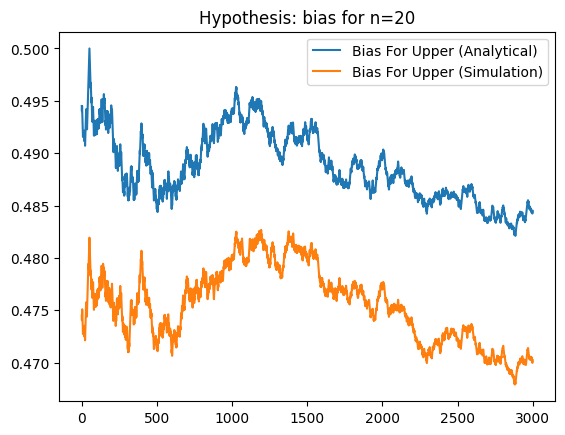

In [148]:
# Extract posterior samples
theta_samples = trace.posterior['theta'].values.ravel()[:1000]  # Shape (1000,)
xu_samples = trace.posterior['xu_'].values  # Shape (chains, draws, n)

sum_xu_samples = xu_samples.sum(axis=-1)  # Shape (chains, draws)


# Compute log likelihoods for all samples at once
marginal_likelihoods_upper = beta_logp_np(sum_xu_samples + alpha0, n - sum_xu_samples + beta0, theta_samples[:, np.newaxis, np.newaxis])

# Average the likelihoods over the samples
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=0)).ravel()

# Convert TensorVariables to numpy arrays
likelihood_prior_pd2 = trace.posterior['likelihood_prior_pd2'].values.ravel()

# Compute biases
bias_for_ml_upper = (likelihood_prior_pd2 - log_marginal_likelihoods_upper) >= 0

# Ensure they are numpy arrays
bias_for_ml_upper = np.array(bias_for_ml_upper)

# Compute cumulative mean of the biases
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)


plt.plot(bias_forupper_mci[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title(f"Hypothesis: bias for n={n}")
plt.legend()
plt.show()

# Estimation

Model

In [156]:
n = 20
x = stats.norm.rvs(size=n)
mu_prior_mean = 0
mu_prior_sigma = 1
with pm.Model() as m:

    # traditional analysis
    mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_, posterior_mean, posterior_var**0.5))
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_,1).sum())

with m:
    idata = pm.sample(draws=1000) #Makes meginal likelihood estimation more accurate)

## Bias against

### Analytic (using posterior density)

In [120]:
bias_against = idata.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000


### Simulation (Estimating marginal likelihood)

In [162]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1)
marginal_likelihoods = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel())

bias_against = idata.posterior['logRB_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)


bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)


#### Plot

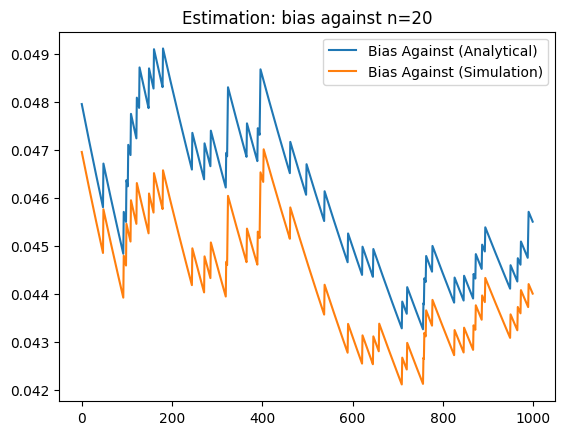

In [163]:
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)');
plt.title("Estimation: bias against n={}".format(n))
plt.legend()

## Bias in favor in 1D

### Analytic (Using posterior density)

In [164]:
n = 50
#x = stats.norm.rvs(size=n)
mu_prior_mean = 0
mu_prior_sigma = 1

delta = 0.05

with pm.Model() as m:

    # traditional analysis
    mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    #y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_lower = pm.Normal('mu_lower', mu=mu_prior_mean - delta, sigma=mu_prior_sigma, shape=1)
    xl_ = pm.Normal('xl_', mu=mu_lower, sigma=1, shape=n)
    mu_upper = pm.Normal('mu_upper', mu=mu_prior_mean + delta, sigma=mu_prior_sigma, shape=1)
    xu_ = pm.Normal('xu_', mu=mu_upper, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pdlower = pm.Deterministic("prior_prior_pdlower", normal_logp(mu_lower,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_meanlower = (mu_prior_mean/mu_prior_sigma**2 + xl_.sum()/1)*posterior_var
    posterior_prior_pdlower = pm.Deterministic("posterior_prior_pdlower",
                                          normal_logp(mu_lower, posterior_meanlower, posterior_var**0.5))
    logRB_prior_pdl = pm.Deterministic("logRB_prior_pdl", posterior_prior_pdlower-prior_prior_pdlower) # pm.math.exp()

    # prior predictive data density evaluations
    prior_prior_pdupper = pm.Deterministic("prior_prior_pdupper", normal_logp(mu_upper,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_meanupper = (mu_prior_mean/mu_prior_sigma**2 + xu_.sum()/1)*posterior_var
    posterior_prior_pdupper = pm.Deterministic("posterior_prior_pdupper",
                                          normal_logp(mu_upper, posterior_meanupper, posterior_var**0.5))
    logRB_prior_pdu = pm.Deterministic("logRB_prior_pdu", posterior_prior_pdupper-prior_prior_pdupper) # pm.math.exp()


    likelihood_prior_pdlower = pm.Deterministic("likelihood_prior_pdlower", normal_logp(xl_,mu_lower,1).sum())
    likelihood_prior_pdupper = pm.Deterministic("likelihood_prior_pdupper", normal_logp(xu_,mu_upper,1).sum())


with m:
    idata = pm.sample(draws=1000)


bias_forlower = idata.posterior['logRB_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logRB_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)

use = 1000
marginal_likelihoodslower = np.zeros(list(idata.posterior['xl_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_lower'].values.ravel()[:use]):
    marginal_likelihoodslower[:,:,:,i] = normal_logp_np(idata.posterior['xl_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoodsupper = np.zeros(list(idata.posterior['xu_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_upper'].values.ravel()[:use]):
    marginal_likelihoodsupper[:,:,:,i] = normal_logp_np(idata.posterior['xu_'].values,m,1)

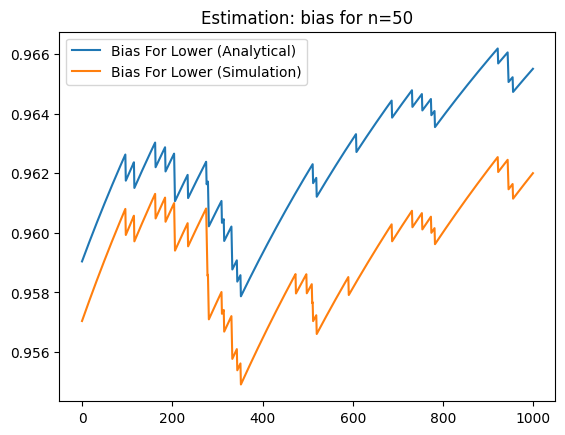

In [165]:
marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoodslower.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mllower = (idata.posterior['likelihood_prior_pdlower'].values.ravel()-marginal_likelihoods_lower) > 0
bias_for_ml_mcilower = bias_for_mllower.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title("Estimation: bias for n={}".format(n))
plt.legend()

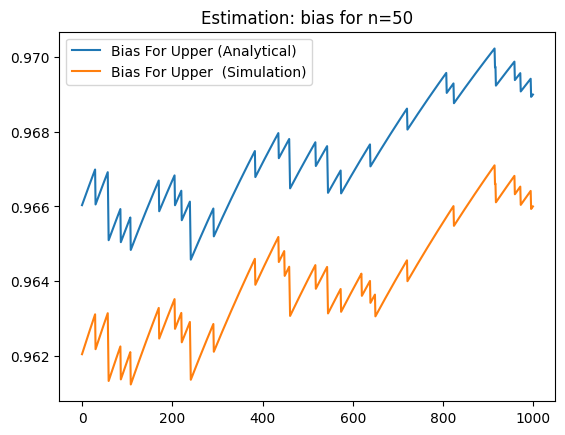

In [125]:
marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoodsupper.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mlupper = (idata.posterior['likelihood_prior_pdupper'].values.ravel()-marginal_likelihoods_upper) > 0
bias_for_ml_mciupper = bias_for_mlupper.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper  (Simulation)')
plt.title("Estimation: bias for n={}".format(n))
plt.legend()

## Beta Binomial model

In [131]:
def beta_logp_np(a, b, x):
    return (a - 1) * np.log(x) + (b - 1) * np.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))



In [132]:
delta = 0.05
n = 20
# theta0 = 0.5

data = np.random.binomial(1, theta0)
alpha0 = 4
beta0 = 4

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    prior_pdlower = pm.Deterministic("prior_pdlower", beta_logp(alpha0, beta0, theta-delta))
    prior_pdupper = pm.Deterministic("prior_pdupper", beta_logp(alpha0, beta0, theta+delta))


    posterior_pd1 = pm.Deterministic("posterior_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta-delta))
    #                                 beta_logp(pm.math.sum(xl_) +alpha0,  n-pm.math.sum(xl_) +beta0, theta-delta))
    posterior_pd2 = pm.Deterministic("posterior_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta+delta))

    #pm.Deterministic("posterior_prior_pd2", beta_logp(pm.math.sum(xu_) +alpha0,  n-pm.math.sum(xu_) +beta0, theta+delta))

    logBR_prior_pd1 = pm.Deterministic("logBR_prior_pd1", posterior_pd1 / prior_pdlower)
    logBR_prior_pd2 = pm.Deterministic("logBR_prior_pd2", posterior_pd2 / prior_pdupper)

    # Likelihood for data
    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", beta_logp(pm.math.sum(xl_) +alpha0,  n-pm.math.sum(xl_) +beta0, theta).sum())
    #likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", beta_logp(pm.math.sum(xu_) +alpha0,  n-pm.math.sum(xu_) +beta0, theta).sum())
    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta).sum())


    # Sample from posterior
    trace = pm.sample(2000, tune=2000)

bias_forlower = trace.posterior['logBR_prior_pd1'].values.ravel() >= 1
bias_forupper = trace.posterior['logBR_prior_pd2'].values.ravel() >= 1
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)

"""
use = 1000
marginal_likelihoodslower = np.zeros(list(trace.posterior['xl_'].values.shape)+[use])
for i,m in enumerate(trace.posterior['theta'].values.ravel()[:use] - delta):
    marginal_likelihoodslower.append(beta_logp_np(trace.posterior['xl_'].values + alpha0, n - trace.posterior['xl_'].values + beta0, m)) # getting likelihoods for each x_ under each mu_

marginal_likelihoodsupper = np.zeros(list(idata.posterior['xu_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_upper'].values.ravel()[:use]):
    marginal_likelihoodsupper[:,:,:,i] = normal_logp_np(idata.posterior['xu_'].values,m,1)"""

"\nuse = 1000\nmarginal_likelihoodslower = np.zeros(list(trace.posterior['xl_'].values.shape)+[use])\nfor i,m in enumerate(trace.posterior['theta'].values.ravel()[:use] - delta):\n    marginal_likelihoodslower.append(beta_logp_np(trace.posterior['xl_'].values + alpha0, n - trace.posterior['xl_'].values + beta0, m)) # getting likelihoods for each x_ under each mu_\n\nmarginal_likelihoodsupper = np.zeros(list(idata.posterior['xu_'].values.shape)+[use])\nfor i,m in enumerate(idata.posterior['mu_upper'].values.ravel()[:use]):\n    marginal_likelihoodsupper[:,:,:,i] = normal_logp_np(idata.posterior['xu_'].values,m,1)"

-0.7972865586692143
[ 1.20574117  0.40581598  1.2157249  ...  1.42403033  1.33937456
 -5.30443594]
-0.7972865586692143


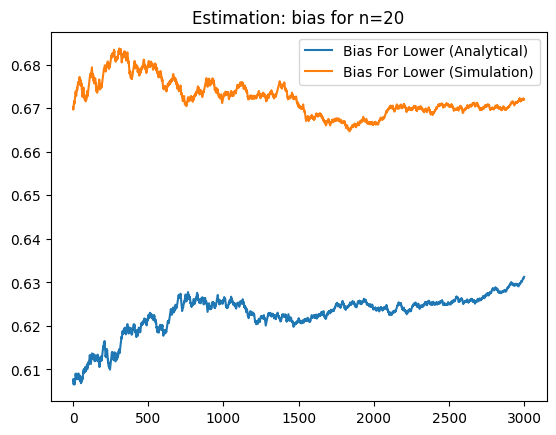

In [133]:

# Calculate the marginal likelihood for lower data
marginal_likelihoods_lower = []
for m in trace.posterior['theta'].values.ravel():
    marginal_likelihoods_lower.append(beta_logp_np(trace.posterior['xl_'].values + alpha0, n - trace.posterior['xl_'].values + beta0, m))

marginal_likelihoods_lower = np.log(np.exp(np.array(marginal_likelihoods_lower)).mean())

print(marginal_likelihoods_lower)

#marginal_likelihoodslower = np.array(marginal_likelihoodslower) # summing the log likelihoods and then taking the average over the parameter samples


print(trace.posterior['likelihood_prior_pd1'].values.ravel())

print(marginal_likelihoods_lower)
bias_for_mllower = (trace.posterior['likelihood_prior_pd1'].values.ravel() - marginal_likelihoods_lower) >= 0
bias_for_ml_mcilower = bias_for_mllower.cumsum()/np.arange(1,tlower+1)


plt.plot(bias_forlower_mci[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title(f"Estimation: bias for n={n}")
plt.legend()
plt.show()

-0.7591514811800731
[ 1.20574117  0.58712095  1.39957116 ...  1.39749284  0.86286767
 -6.92042495]


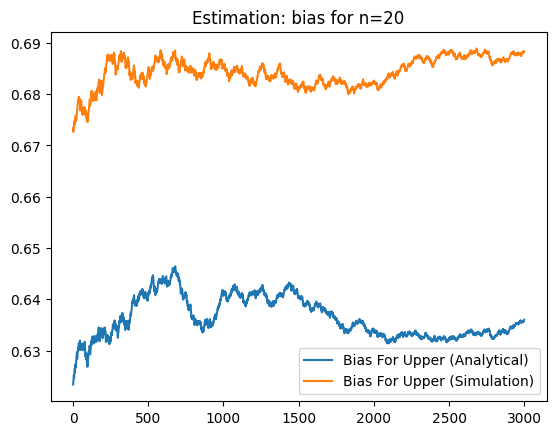

In [135]:

# Calculate the marginal likelihood for lower data
marginal_likelihoods_upper = []
for m in trace.posterior['theta'].values.ravel():
    marginal_likelihoods_upper.append(beta_logp_np(trace.posterior['xu_'].values + alpha0, n - trace.posterior['xu_'].values + beta0, m))

marginal_likelihoods_upper = np.log(np.exp(np.array(marginal_likelihoods_upper)).mean())

print(marginal_likelihoods_upper)

#marginal_likelihoodslower = np.array(marginal_likelihoodslower) # summing the log likelihoods and then taking the average over the parameter samples


print(trace.posterior['likelihood_prior_pd2'].values.ravel())


bias_for_mlupper = (trace.posterior['likelihood_prior_pd2'].values.ravel() - marginal_likelihoods_upper) >= 0
bias_for_ml_mciupper = bias_for_mlupper.cumsum()/np.arange(1,tlower+1)


plt.plot(bias_forupper_mci[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title(f"Estimation: bias for n={n}")
plt.legend()
plt.show()

# Relative Belief ratios

In [ ]:
np.random.seed(1234)
data = np.random.uniform(0, 10, size=100)
with pm.Model() as model:
    # Prior
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    # Sample posterior
    trace = pm.sample(2000, tune=1000)

# Extract posterior samples
posterior_samples = trace.posterior['mu'].values.flatten()




<ipython-input-8-87221d08c27d>:40: RuntimeWarning: invalid value encountered in divide
  rbr = smoothed_posterior_hist / smoothed_prior_hist


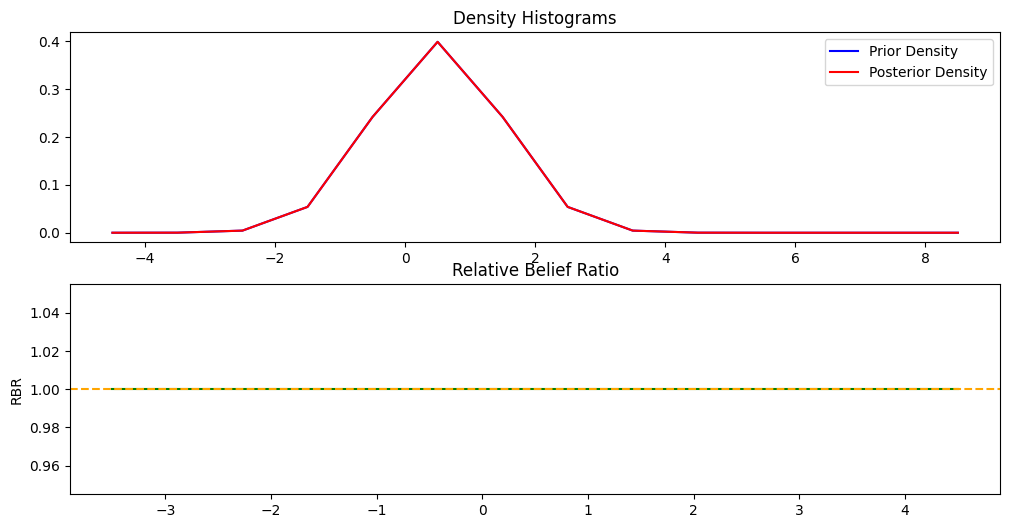

In [ ]:
n = 100
theta0 = 0.5
data = np.random.binomial(1, theta0, n)

alpha0 = 4
beta0 = 4

# Create the PyMC model
with pm.Model() as modBias:
    # Prior distribution
    theta_prior = pm.Beta('theta', alpha=alpha0, beta=beta0)

    # Likelihood
    likelihood = pm.Binomial('likelihood', n=n, p=theta0, observed=data)

    # Posterior distribution
    posterior = pm.Beta('posterior', alpha=np.sum(data) + alpha0, beta=n - np.sum(data) + beta0)

    # Calculate the ratio of posterior to prior
    #BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior / theta_prior)

    # Sample the model
    trace = pm.sample(2000, tune=1000)

delta = 1
bins = np.arange(-5, 10, delta)

# Prior histogram
prior_samples = np.random.beta(alpha0, beta0, size=10000)
prior_hist, _ = np.histogram(prior_samples, bins=bins, density=True)

# Posterior histogram
posterior_hist, _ = np.histogram(trace.posterior['posterior'], bins=bins, density=True)

# Smoothing
smoothed_prior_hist = gaussian_filter1d(prior_hist, sigma=1)
smoothed_posterior_hist = gaussian_filter1d(posterior_hist, sigma=1)

# Compute RBR by taking ratio
rbr = smoothed_posterior_hist / smoothed_prior_hist

# Plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bin_centers, smoothed_prior_hist, label='Prior Density', color='blue')
plt.plot(bin_centers, smoothed_posterior_hist, label='Posterior Density', color='red')
plt.legend()
plt.title('Density Histograms')

plt.subplot(2, 1, 2)
plt.plot(bin_centers, rbr, color='green')
plt.title('Relative Belief Ratio')
plt.ylabel('RBR')
plt.axhline(y=1, color='orange', linestyle='--')
plt.show()

### Analytic (Using posterior and prior ratio)

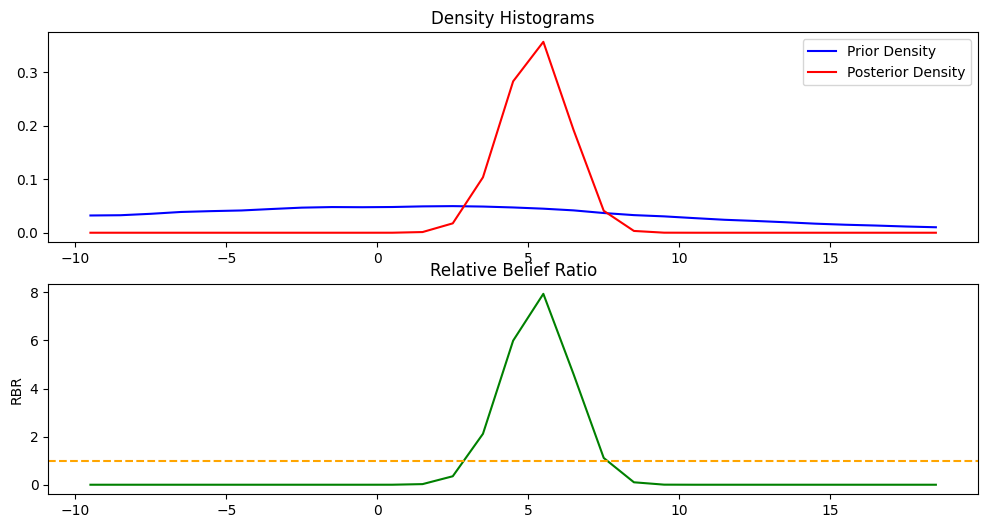

In [ ]:
delta = 1 #Meaningful difference
bins = np.arange(-10, 20, delta)

# Prior histogram
prior_samples = np.random.normal(0, 10, size=10000)
prior_hist, _ = np.histogram(prior_samples, bins=bins, density=True)

# Posterior histogram
posterior_hist, _ = np.histogram(posterior_samples, bins=bins, density=True)

# Smoothing
smoothed_prior_hist = gaussian_filter1d(prior_hist, sigma=1)
smoothed_posterior_hist = gaussian_filter1d(posterior_hist, sigma=1)

# Compute RBR by taking ratio
rbr = smoothed_posterior_hist / smoothed_prior_hist

# Plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bin_centers, smoothed_prior_hist, label='Prior Density', color='blue')
plt.plot(bin_centers, smoothed_posterior_hist, label='Posterior Density', color='red')
plt.legend()
plt.title('Density Histograms')

plt.subplot(2, 1, 2)
plt.plot(bin_centers, rbr, color='green')
plt.title('Relative Belief Ratio')
plt.ylabel('RBR')
plt.axhline(y=1, color='orange', linestyle='--')
plt.show()


### Simulation

In [ ]:
#Not done yet